In [1]:
!nvidia-smi

Mon Nov 23 20:16:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 53kB/s 


In [2]:

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:

# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Tomato_Dataset/train'
valid_path = '/content/drive/MyDrive/Tomato_Dataset/valid'

In [5]:
 import tensorflow as tf

callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

In [6]:

# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [7]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [8]:

# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Tomato_Dataset/train/*')

In [9]:
folders

['/content/drive/MyDrive/Tomato_Dataset/train/Tomato___Bacterial_spot',
 '/content/drive/MyDrive/Tomato_Dataset/train/Tomato___Early_blight',
 '/content/drive/MyDrive/Tomato_Dataset/train/Tomato___Septoria_leaf_spot',
 '/content/drive/MyDrive/Tomato_Dataset/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 '/content/drive/MyDrive/Tomato_Dataset/train/Tomato___Tomato_mosaic_virus',
 '/content/drive/MyDrive/Tomato_Dataset/train/Tomato___healthy',
 '/content/drive/MyDrive/Tomato_Dataset/train/Tomato___Spider_mites Two-spotted_spider_mite',
 '/content/drive/MyDrive/Tomato_Dataset/train/Tomato___Target_Spot',
 '/content/drive/MyDrive/Tomato_Dataset/train/Tomato___Leaf_Mold',
 '/content/drive/MyDrive/Tomato_Dataset/train/Tomato___Late_blight']

In [10]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [11]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [12]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Tomato_Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 18345 images belonging to 10 classes.


In [17]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Tomato_Dataset/valid',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 4585 images belonging to 10 classes.


In [95]:
#Model Training

In [96]:
# We can evaluate the model right now to see how it does before training it on our new images
#initial_epochs = 3
#validation_steps=32

#loss0,accuracy0 = model.evaluate(training_set, steps = validation_steps)

In [97]:
from datetime import datetime
import time
from sklearn.metrics import accuracy_score
from keras import backend as K
from keras.callbacks import ModelCheckpoint
fmt = '%H:%M:%S'
def get_current_time():
    time.ctime()
    return time.strftime(fmt)
first = get_current_time()

In [98]:

# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[callback]
)

Epoch 1/50
287/287 [==============================] - 13622s 47s/step - loss: 2.1700 - accuracy: 0.6892 - val_loss: 1.4128 - val_accuracy: 0.7575
Epoch 2/50
287/287 [==============================] - 233s 811ms/step - loss: 1.2200 - accuracy: 0.8009 - val_loss: 1.5073 - val_accuracy: 0.7887
Epoch 3/50
287/287 [==============================] - 226s 788ms/step - loss: 1.2320 - accuracy: 0.8210 - val_loss: 1.0512 - val_accuracy: 0.8482
Epoch 4/50
287/287 [==============================] - 230s 803ms/step - loss: 1.0381 - accuracy: 0.8539 - val_loss: 1.9169 - val_accuracy: 0.7915
Epoch 5/50
287/287 [==============================] - 245s 852ms/step - loss: 1.1395 - accuracy: 0.8556 - val_loss: 1.7535 - val_accuracy: 0.8113
Epoch 6/50
287/287 [==============================] - 249s 866ms/step - loss: 1.0748 - accuracy: 0.8704 - val_loss: 1.6582 - val_accuracy: 0.8203
Epoch 7/50
287/287 [==============================] - 250s 871ms/step - loss: 1.0238 - accuracy: 0.8797 - val_loss: 1.4134 -

In [99]:

second = get_current_time()
print("Time taken to train(sec):", datetime.strptime(second, fmt) - datetime.strptime(first, fmt))

Time taken to train(sec): 4:16:40


In [100]:
len(r.history['loss']) 

8

In [101]:

import time
import os

def saveModel_path(model_dir="/content/drive/My Drive/"):
    os.makedirs(model_dir, exist_ok=True)
    fileName = time.strftime("Tomato_Model.h5")    
    model_path = os.path.join(model_dir, fileName)
    print(f"your model will be saved at the following location\n{model_path}")
    return model_path

In [102]:
UNIQUE_PATH = model.save(saveModel_path())

your model will be saved at the following location
/content/drive/My Drive/Tomato_Model.h5


In [18]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Tomato_Model.h5')

In [104]:
r.params

{'epochs': 50, 'steps': 287, 'verbose': 1}

In [ ]:
import pandas as pd
pd.DataFrame(r.history)

In [106]:
import matplotlib.pyplot as plt

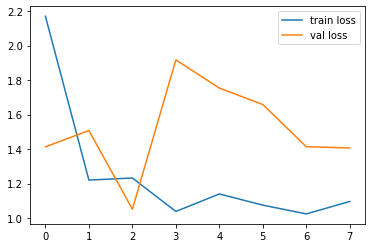

<Figure size 432x288 with 0 Axes>

In [107]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

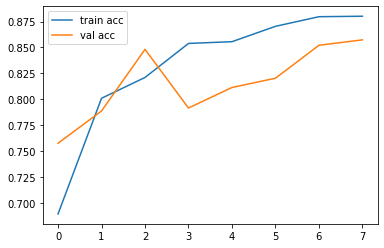

<Figure size 432x288 with 0 Axes>

In [108]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [109]:

from tensorflow.keras.models import load_model

model.save('tomato.h5')

In [110]:
y_pred = model.predict(test_set)

In [111]:
y_pred

array([[3.3006108e-24, 6.2702270e-12, 1.0064621e-21, ..., 1.2987320e-22,
        4.6594983e-29, 1.4674155e-18],
       [0.0000000e+00, 1.1947359e-30, 8.2560973e-27, ..., 0.0000000e+00,
        1.6668968e-37, 1.0000000e+00],
       [2.7533081e-13, 6.4275099e-13, 4.5581238e-14, ..., 6.6112318e-17,
        8.4245547e-20, 2.5724585e-23],
       ...,
       [1.2101019e-37, 3.8961144e-26, 3.0334537e-25, ..., 1.0000000e+00,
        3.4554478e-30, 4.3090684e-34],
       [3.8953355e-14, 3.9888541e-13, 5.4190039e-09, ..., 2.3205017e-19,
        1.0000000e+00, 2.2843578e-21],
       [1.5552199e-07, 3.9365161e-02, 8.3893800e-01, ..., 6.0195455e-12,
        2.3618538e-10, 3.3502063e-06]], dtype=float32)

In [112]:

import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [113]:
y_pred

array([6, 9, 4, ..., 7, 8, 2])

In [114]:
#Confution Matrix and Classification Report
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
num_of_test_samples = 384
batch_size = 20
Y_pred = model.predict_generator(test_set, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
#target_names = ['cardboard','ewaste','glass','metal','paper','plastic','trash']
print(classification_report(test_set.classes, y_pred))



plt.figure(figsize=(10,10))
cm = confusion_matrix(test_set.classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix


ValueError: ignored